In [1]:
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import pyplot

In [2]:
from google.colab import files

files.upload()

Saving 상명대_전력수요예측_지수평활 sheet1.xlsx to 상명대_전력수요예측_지수평활 sheet1.xlsx


{'상명대_전력수요예측_지수평활 sheet1.xlsx': b'PK\x03\x04\x14\x00\x06\x00\x08\x00\x00\x00!\x00\x9e,lok\x01\x00\x00\x10\x05\x00\x00\x13\x00\x08\x02[Content_Types].xml \xa2\x04\x02(\xa0\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x

In [3]:
# 데이터 입력 
import openpyxl
filename = "상명대_전력수요예측_지수평활 sheet1.xlsx" 
book = openpyxl.load_workbook(filename) #엑셀파일 book 변수에 저장
sheet=book.worksheets[0] #첫번째 워크시트 저장

In [4]:
 data = []
 for row in sheet.rows: #전체 행에대하여 반복 실행
   data.append([
              row[0].value, #1열 데이터
              row[1].value, #2열 데이터
              row[2].value, #3열 데이터
              row[3].value, #4열 데이터
              row[4].value, #5열 데이터
              row[5].value  #6열 데이터
              ])

In [5]:
import math
import pandas as pd
import numpy as np
data=pd.DataFrame(data[3:])
data.columns=["Name","No","Date","Time","P.D","Temp"]
data

Name  No       Date  Time       P.D  Temp
0      신정   8 2018-01-01     1  6151.290  -3.2
1      신정   8 2018-01-01     2  6035.190  -3.3
2      신정   8 2018-01-01     3  6000.090  -3.7
3      신정   8 2018-01-01     4  5970.930  -4.0
4      신정   8 2018-01-01     5  6025.200  -4.2
...   ...  ..        ...   ...       ...   ...
8755    0   1 2018-12-31    20  7457.955  -3.7
8756    0   1 2018-12-31    21  7005.975  -4.6
8757    0   1 2018-12-31    22  6709.110  -5.4
8758    0   1 2018-12-31    23  6332.730  -5.2
8759    0   1 2018-12-31    24  6096.750  -5.5

[8760 rows x 6 columns]

#**전력만 사용**

In [ ]:
columns = ['P.D']
data_ = data[columns]
data_

P.D
0     6151.290
1     6035.190
2     6000.090
3     5970.930
4     6025.200
...        ...
8755  7457.955
8756  7005.975
8757  6709.110
8758  6332.730
8759  6096.750

[8760 rows x 1 columns]

In [ ]:
# split a univariate dataset into train/test sets
def train_test_split(data):
  train=int(len(data)*0.8) #train
  return data[:train],data[train:]


In [ ]:
# transform list into supervised learning format
def series_to_supervised(m_data, n_in, n_out=1):
	m_data.dropna(inplace=True)
	train_series = [] 
	target_series = [] 
  
	for i in range(0, len(m_data)-2):
		row = [] # row represents a train series, in this case, [[111, -1], [112, -2]]
		count = i # count is the variable to access the target value, in this case, 113
		for j in range(2):
        # a row = [111, -1]
			row.append([value for value in m_data.iloc[i+j]])
			count += 1
		train_series.append(row)
		target_series.append(m_data.iloc[count].values[0])
    # ----
	train_series = np.array(train_series, dtype="float32")
	target_series = np.array(target_series, dtype="float32")
	return train_series, target_series

In [ ]:
def measure_error(actual, predicted):
  actual=np.array(actual)
  predicted=np.array(predicted)
  result=np.mean(np.abs((actual-predicted)/actual)*100)
  return result

In [ ]:
# fit a model
def model_fit(train, config):  
	# unpack config
	n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config  #config = [1, 2, 64, 3, 200, 350, 100]
	n_input = n_seq * n_steps

	# prepare data
	data = series_to_supervised(train, n_input,1)
	train_x, train_y = data[:-1], data[-1]  #train중, data[:, :-1]=마지막값 제외, data[:, -1]=마지막값
	train_x = np.asarray(train_x)
	train_x = train_x.reshape((train_x.shape[1], n_seq, n_steps, 1))  #input
 
	# define model
	model = Sequential()
 #TimeDistributed= 각 스텝마다 cost(오류)를 계산해서 하위 스텝으로 오류를 전파하여 각 weight를 업데이트하라는 의미
	model.add(TimeDistributed(Conv1D(n_filters, n_kernel,padding='same',activation='relu', input_shape=(None,n_steps,1))))
	# model.add(TimeDistributed(Conv1D(n_filters, n_kernel, activation='relu')))
	model.add(TimeDistributed(Conv1D(n_filters, n_kernel,padding='same',activation='relu')))
#	model.add(TimeDistributed(Conv1D(n_filters, n_kernel, activation='relu')))
	model.add(TimeDistributed(MaxPooling1D()))
	model.add(TimeDistributed(Flatten()))
	model.add(LSTM(n_nodes, activation='relu'))
	model.add(Dense(n_nodes, activation='relu'))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=1)
	return model

In [ ]:
# forecast with a pre-fit model
def model_predict(model, history, config):  
	# unpack config
	n_seq, n_steps, _, _, _, _, _ = config
	n_input = n_seq * n_steps
	# prepare data
	x_input = array(history[-n_input:]).reshape((1, n_seq, n_steps, 1))
	# forecast
	yhat = model.predict(x_input,verbose=0)
	return yhat[0]

In [ ]:
import matplotlib.pyplot as plt
def draw_graph(test,predictions):
	fig = plt.figure(figsize=(10, 5))
	ax1 = fig.add_subplot(1, 1, 1)
	ax1.plot(test, 'b', label='Original')
	ax1.plot(predictions, 'r', label='Prediction')
	ax1.legend(loc="lower right")

In [ ]:
# walk-forward validation for univariate(단변량=종속변수 한개) data
#학습 및 에러계산
def walk_forward_validation(data, n_test, cfg):   
	predictions = list()
	# split dataset
	train, test = train_test_split(data) 
	# fit model
	model = model_fit(train, cfg)
	print('finish training')
	# seed history with training dataset
	history = [x for x in train.values] 
	test=[x for x in test.values]  

	# step over each time-step in the test set
	for i in range(len(test)):
		yhat = model_predict(model, history, cfg)
		# store forecast in list of, 예측값모음=predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		test_=np.array(test)

	# estimate prediction errorrint("pre") 에러율 계산 
	error = measure_error(test_, predictions)  
	print(' > %.3f' % error)
	draw_graph(test_,predictions)
	print(test_)
	print(predictions)
	return error

In [ ]:
# repeat evaluation of a config
#전체 에러 계산 
def repeat_evaluate(data, config, n_test, n_repeats=10):
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]  #error 저장
	return scores

In [ ]:
# summarize model performance
def summarize_scores(name, scores):
	# print a summary
	scores_m, score_std = mean(scores), std(scores)
	print('%s: %.3f error (+/- %.3f)' % (name, scores_m, score_std))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
71/71 [==============================] - 2s 10ms/step - loss: 42013231.7500
Epoch 2/350
71/71 [==============================] - 1s 10ms/step - loss: 513953.9605
Epoch 3/350
71/71 [==============================] - 1s 10ms/step - loss: 288634.5888
Epoch 4/350
71/71 [==============================] - 1s 10ms/step - loss: 242232.7480
Epoch 5/350
71/71 [==============================] - 1s 10ms/step - loss: 198434.2792
Epoch 6/350
71/71 [==============================] - 1s 11ms/step - loss: 263246.4310
Epoch 7/350
71/71 [==============================] - 1s 10ms/step - loss: 217086.7930
Epoch 8/350
71/71 [==============================] - 1s 10ms/step - loss: 209378.1393
Epoch 9/350
71/71 [==============================] - 1s 10ms/step - loss: 210453.1385
Epoch 10/350
71/71 [==============================] - 1s 10ms/step - loss: 231281.4701
Epoch 11/350
71/71 [==============================] - 1s 10ms/step - loss: 234747.8631
Epoch 12/350
71/71 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
71/71 [==============================] - 2s 10ms/step - loss: 35419457.0972
Epoch 2/350
71/71 [==============================] - 1s 10ms/step - loss: 517816.7964
Epoch 3/350
71/71 [==============================] - 1s 10ms/step - loss: 303706.1760
Epoch 4/350
71/71 [==============================] - 1s 10ms/step - loss: 222278.3461
Epoch 5/350
71/71 [==============================] - 1s 10ms/step - loss: 257651.3646
Epoch 6/350
71/71 [==============================] - 1s 10ms/step - loss: 212404.1424
Epoch 7/350
71/71 [==============================] - 1s 10ms/step - loss: 215800.6189
Epoch 8/350
71/71 [==============================] - 1s 10ms/step - loss: 213191.9336
Epoch 9/350
71/71 [==============================] - 1s 10ms/step - loss: 250784.3266
Epoch 10/350
71/71 [==============================] - 1s 10ms/step - loss: 223232.5760
Epoch 11/350
71/71 [==============================] - 1s 10ms/step - loss: 205939.3012
Epoch 12/350
71/71 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
71/71 [==============================] - 2s 11ms/step - loss: 35456067.2500
Epoch 2/350
71/71 [==============================] - 1s 11ms/step - loss: 483495.7235
Epoch 3/350
71/71 [==============================] - 1s 11ms/step - loss: 333453.5187
Epoch 4/350
71/71 [==============================] - 1s 11ms/step - loss: 240350.7865
Epoch 5/350
71/71 [==============================] - 1s 11ms/step - loss: 222348.0289
Epoch 6/350
71/71 [==============================] - 1s 10ms/step - loss: 212000.9056
Epoch 7/350
71/71 [==============================] - 1s 11ms/step - loss: 211516.3192
Epoch 8/350
71/71 [==============================] - 1s 11ms/step - loss: 228605.6447
Epoch 9/350
71/71 [==============================] - 1s 11ms/step - loss: 210906.5508
Epoch 10/350
71/71 [==============================] - 1s 11ms/step - loss: 212026.7808
Epoch 11/350
71/71 [==============================] - 1s 11ms/step - loss: 210344.2248
Epoch 12/350
71/71 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
71/71 [==============================] - 2s 11ms/step - loss: 31681094.4583
Epoch 2/350
71/71 [==============================] - 1s 11ms/step - loss: 494847.7474
Epoch 3/350
71/71 [==============================] - 1s 11ms/step - loss: 435077.0174
Epoch 4/350
71/71 [==============================] - 1s 11ms/step - loss: 327106.3572
Epoch 5/350
71/71 [==============================] - 1s 11ms/step - loss: 253461.7020
Epoch 6/350
71/71 [==============================] - 1s 11ms/step - loss: 214036.5080
Epoch 7/350
71/71 [==============================] - 1s 11ms/step - loss: 248067.6780
Epoch 8/350
71/71 [==============================] - 1s 11ms/step - loss: 222517.2812
Epoch 9/350
71/71 [==============================] - 1s 11ms/step - loss: 197269.2572
Epoch 10/350
71/71 [==============================] - 1s 11ms/step - loss: 228907.2025
Epoch 11/350
71/71 [==============================] - 1s 11ms/step - loss: 226868.4013
Epoch 12/350
71/71 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
71/71 [==============================] - 2s 12ms/step - loss: 27492386.0417
Epoch 2/350
71/71 [==============================] - 1s 12ms/step - loss: 410142.3385
Epoch 3/350
71/71 [==============================] - 1s 12ms/step - loss: 262514.1706
Epoch 4/350
71/71 [==============================] - 1s 12ms/step - loss: 234975.9883
Epoch 5/350
71/71 [==============================] - 1s 12ms/step - loss: 248816.7624
Epoch 6/350
71/71 [==============================] - 1s 11ms/step - loss: 209884.3863
Epoch 7/350
71/71 [==============================] - 1s 11ms/step - loss: 231162.4993
Epoch 8/350
71/71 [==============================] - 1s 11ms/step - loss: 217563.8244
Epoch 9/350
71/71 [==============================] - 1s 12ms/step - loss: 217748.1717
Epoch 10/350
71/71 [==============================] - 1s 11ms/step - loss: 200283.9076
Epoch 11/350
71/71 [==============================] - 1s 12ms/step - loss: 210384.9538
Epoch 12/350
71/71 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
71/71 [==============================] - 2s 12ms/step - loss: 34465015.2083
Epoch 2/350
71/71 [==============================] - 1s 12ms/step - loss: 463278.9193
Epoch 3/350
71/71 [==============================] - 1s 12ms/step - loss: 243141.4160
Epoch 4/350
71/71 [==============================] - 1s 11ms/step - loss: 209462.3503
Epoch 5/350
71/71 [==============================] - 1s 11ms/step - loss: 237003.6057
Epoch 6/350
71/71 [==============================] - 1s 13ms/step - loss: 215715.3362
Epoch 7/350
71/71 [==============================] - 1s 12ms/step - loss: 220712.9447
Epoch 8/350
71/71 [==============================] - 1s 12ms/step - loss: 212099.2706
Epoch 9/350
71/71 [==============================] - 1s 12ms/step - loss: 216465.7352
Epoch 10/350
71/71 [==============================] - 1s 12ms/step - loss: 202858.5297
Epoch 11/350
71/71 [==============================] - 1s 11ms/step - loss: 207241.1280
Epoch 12/350
71/71 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
71/71 [==============================] - 2s 11ms/step - loss: 37906393.5417
Epoch 2/350
71/71 [==============================] - 1s 11ms/step - loss: 575752.0668
Epoch 3/350
71/71 [==============================] - 1s 11ms/step - loss: 427651.6845
Epoch 4/350
71/71 [==============================] - 1s 12ms/step - loss: 260547.7415
Epoch 5/350
71/71 [==============================] - 1s 12ms/step - loss: 215566.5684
Epoch 6/350
71/71 [==============================] - 1s 12ms/step - loss: 248894.3322
Epoch 7/350
71/71 [==============================] - 1s 11ms/step - loss: 210010.1506
Epoch 8/350
71/71 [==============================] - 1s 11ms/step - loss: 209679.2700
Epoch 9/350
71/71 [==============================] - 1s 11ms/step - loss: 213531.3863
Epoch 10/350
71/71 [==============================] - 1s 12ms/step - loss: 216744.3331
Epoch 11/350
71/71 [==============================] - 1s 11ms/step - loss: 220133.0705
Epoch 12/350
71/71 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
71/71 [==============================] - 2s 12ms/step - loss: 31222219.2778
Epoch 2/350
71/71 [==============================] - 1s 12ms/step - loss: 517712.2995
Epoch 3/350
71/71 [==============================] - 1s 12ms/step - loss: 343690.7665
Epoch 4/350
71/71 [==============================] - 1s 12ms/step - loss: 273797.7168
Epoch 5/350
71/71 [==============================] - 1s 11ms/step - loss: 220830.7407
Epoch 6/350
71/71 [==============================] - 1s 12ms/step - loss: 227625.4701
Epoch 7/350
71/71 [==============================] - 1s 12ms/step - loss: 226799.3168
Epoch 8/350
71/71 [==============================] - 1s 12ms/step - loss: 229988.4032
Epoch 9/350
71/71 [==============================] - 1s 11ms/step - loss: 205327.3952
Epoch 10/350
71/71 [==============================] - 1s 12ms/step - loss: 212562.7806
Epoch 11/350
71/71 [==============================] - 1s 12ms/step - loss: 222696.2405
Epoch 12/350
71/71 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
71/71 [==============================] - 2s 12ms/step - loss: 32725275.1806
Epoch 2/350
71/71 [==============================] - 1s 12ms/step - loss: 492536.9149
Epoch 3/350
71/71 [==============================] - 1s 12ms/step - loss: 332471.9666
Epoch 4/350
71/71 [==============================] - 1s 11ms/step - loss: 281019.0592
Epoch 5/350
71/71 [==============================] - 1s 12ms/step - loss: 231961.3492
Epoch 6/350
71/71 [==============================] - 1s 12ms/step - loss: 200294.9208
Epoch 7/350
71/71 [==============================] - 1s 12ms/step - loss: 227548.5837
Epoch 8/350
71/71 [==============================] - 1s 12ms/step - loss: 214053.4457
Epoch 9/350
71/71 [==============================] - 1s 12ms/step - loss: 210330.0707
Epoch 10/350
71/71 [==============================] - 1s 12ms/step - loss: 233088.3010
Epoch 11/350
71/71 [==============================] - 1s 12ms/step - loss: 222165.2224
Epoch 12/350
71/71 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
71/71 [==============================] - 2s 13ms/step - loss: 35723406.9722
Epoch 2/350
71/71 [==============================] - 1s 13ms/step - loss: 543238.9501
Epoch 3/350
71/71 [==============================] - 1s 14ms/step - loss: 251341.6812
Epoch 4/350
71/71 [==============================] - 1s 13ms/step - loss: 255187.2203
Epoch 5/350
71/71 [==============================] - 1s 14ms/step - loss: 236489.2535
Epoch 6/350
71/71 [==============================] - 1s 13ms/step - loss: 231194.7439
Epoch 7/350
71/71 [==============================] - 1s 13ms/step - loss: 222685.5067
Epoch 8/350
71/71 [==============================] - 1s 13ms/step - loss: 215190.2520
Epoch 9/350
71/71 [==============================] - 1s 13ms/step - loss: 218797.0508
Epoch 10/350
71/71 [==============================] - 1s 14ms/step - loss: 206215.7949
Epoch 11/350
71/71 [==============================] - 1s 13ms/step - loss: 215917.3084
Epoch 12/350
71/71 [==============================

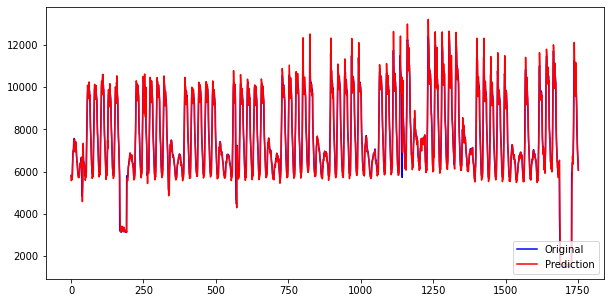

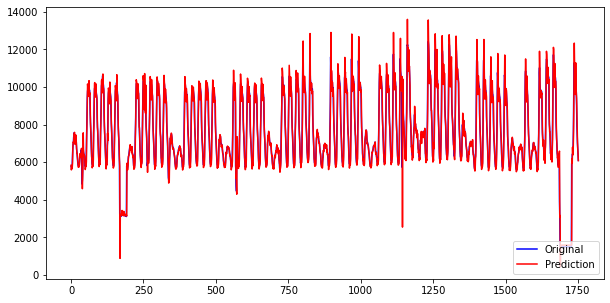

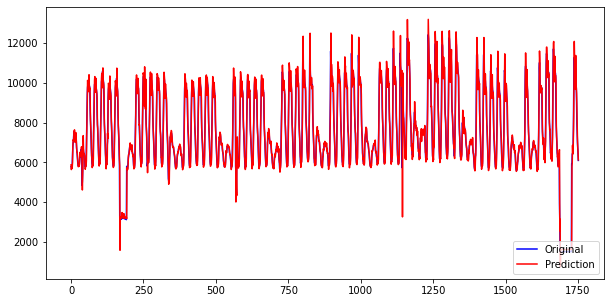

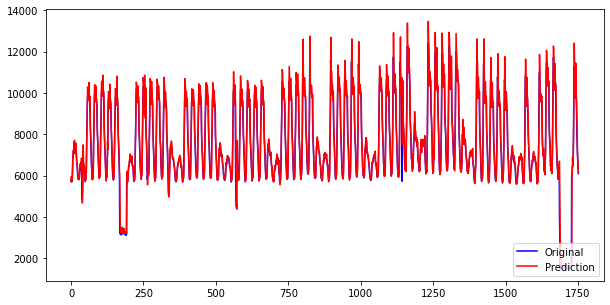

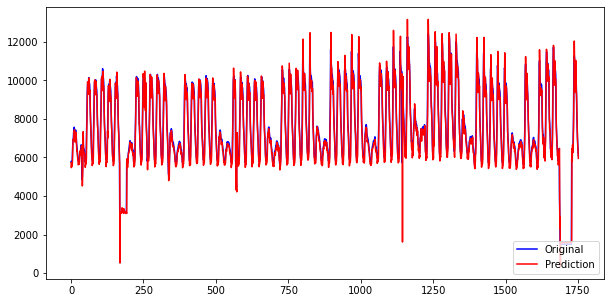

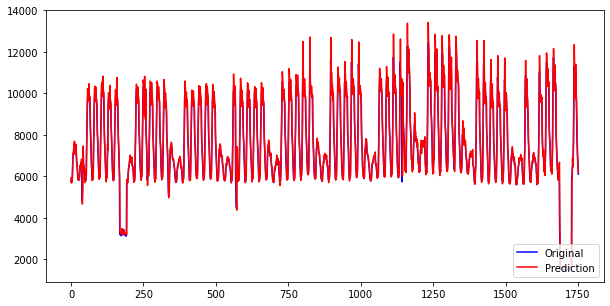

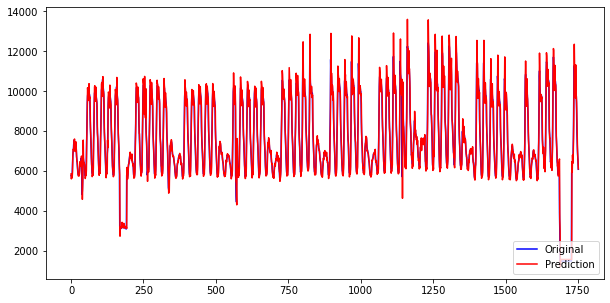

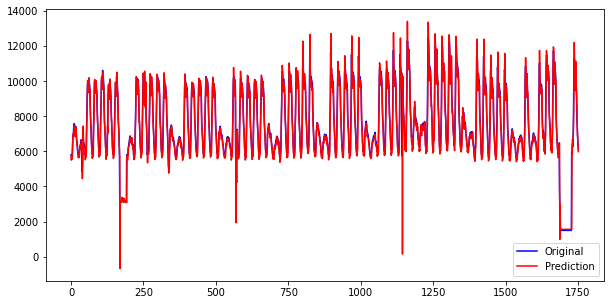

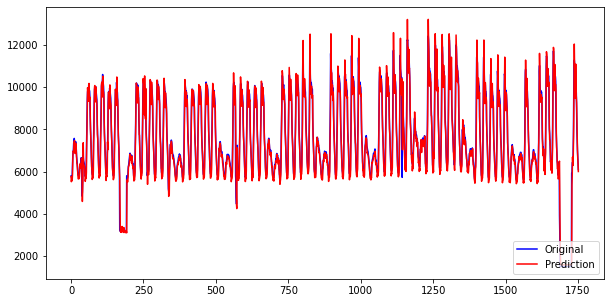

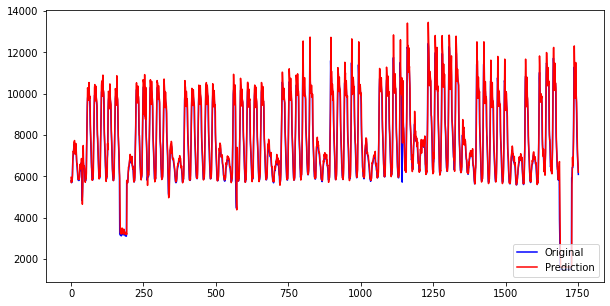

In [ ]:
from tensorflow.python.keras.callbacks import EarlyStopping
# data split
n_test = 2

# define config 
# n seq: The number of subsequences within a sample.
# n steps: The number of time steps within each subsequence.
# n filters: The number of parallel filters.
# n kernel: The number of time steps considered in each read of the input sequence.
# n nodes: The number of LSTM units to use in the hidden layer.
# n epochs: The number of times to expose the model to the whole training dataset.
# n batch: The number of samples within an epoch after which the weights are updated.

config = [1, 2, 64, 3, 200, 350, 100]
# grid search
scores = repeat_evaluate(data_, config, n_test)
# summarize scores
summarize_scores('cnn-lstm', scores)

# **전력+온도**

In [6]:
columns = ['P.D', 'Temp']
data2 = data[columns]
data2

P.D  Temp
0     6151.290  -3.2
1     6035.190  -3.3
2     6000.090  -3.7
3     5970.930  -4.0
4     6025.200  -4.2
...        ...   ...
8755  7457.955  -3.7
8756  7005.975  -4.6
8757  6709.110  -5.4
8758  6332.730  -5.2
8759  6096.750  -5.5

[8760 rows x 2 columns]

In [7]:
# split a univariate dataset into train/test sets
def train_test_split(data):
  train=int(len(data)*0.8) #train
  return data[:train],data[train:]

In [8]:
# transform list into supervised learning format
def series_to_supervised(m_data, n_in, n_out=1):
	m_data.dropna(inplace=True)
	train_series = [] 
	target_series = []
    # ---- Change these code for target values ----
	for i in range(0, len(m_data)-2):
		row = [] # row represents a train series, in this case, [[111, -1], [112, -2]]
		count = i # count is the variable to access the target value, in this case, 113
		for j in range(2):
        # a row = [111, -1]
			row.append([value for value in m_data.loc[i+j].values])
			count += 1
		train_series.append(row)
		target_series.append(m_data.loc[count].values[0])
    # ----
	train_series = np.array(train_series, dtype="float32")
	target_series = np.array(target_series, dtype="float32")
	return train_series, target_series

In [9]:
def measure_error(actual, predicted):
  actual=np.array(actual)
  predicted=np.array(predicted)
  result=np.mean(np.abs((actual-predicted)/actual)*100)
  return result

In [10]:
# fit a model
def model_fit(train, config):
	# unpack config
	n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
	n_input = n_seq * n_steps
	# prepare series_train
	series_train_x, series_train_y = series_to_supervised(train,n_input)
	series_train_x = series_train_x.reshape((series_train_x.shape[0], n_seq, n_steps, -1))  #하는이유
	# define model
	model = Sequential()
	model.add(TimeDistributed(Conv1D(n_filters, n_kernel,padding='same',activation='relu', input_shape=(None,n_steps))))
	model.add(TimeDistributed(Conv1D(n_filters, n_kernel,padding='same',activation='relu')))
#	model.add(TimeDistributed(Conv1D(n_filters, n_kernel, activation='relu')))
	model.add(TimeDistributed(MaxPooling1D()))
	model.add(TimeDistributed(Flatten()))
	model.add(LSTM(n_nodes, activation='relu'))
	model.add(Dense(n_nodes, activation='relu'))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam') 
 
 #validation 사용할때 earlystopping 사용
 #fit
	model.fit(series_train_x, series_train_y, epochs=n_epochs, batch_size=n_batch, verbose=1)
	return model

In [11]:
# forecast with a pre-fit model
def model_predict(model, history, config): 
	# unpack config
	n_seq, n_steps, _, _, _, _, _ = config
	n_input = n_seq * n_steps
	# prepare data
	x_input = array(history[-n_input:]).reshape((1, n_seq, n_steps,2))

	# forecast
	yhat = model.predict(x_input, verbose=0)
	return yhat[0]

In [12]:
import matplotlib.pyplot as plt
def draw_graph(test,predictions):
  fig = plt.figure(figsize=(10, 5))
  ax1 = fig.add_subplot(1, 1, 1)
  ax1.plot(test, 'b', label='Original')
  ax1.plot(predictions, 'r', label='Prediction')
  ax1.legend(loc="lower right")

In [13]:
# walk-forward validation for univariate data2
def walk_forward_validation(data2, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data2)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train.values]
	test=[x for x in test.values]  #shape=(12,2)
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of 
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction errorrint("pre")
	test_=np.array(test)[:,0]
	error = measure_error(test_, predictions)
	print(' > %.3f' % error)
	draw_graph(test_,predictions)
	print(test_)
	print(predictions)
	return error

In [14]:
# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=10):
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	return scores

In [15]:
# summarize model performance
def summarize_scores(name, scores):
	# print a summary
	scores_m, score_std = mean(scores), std(scores)
	print('%s: %.3f error (+/- %.3f)' % (name, scores_m, score_std))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
71/71 [==============================] - 2s 8ms/step - loss: 33136616.1667
Epoch 2/350
71/71 [==============================] - 1s 8ms/step - loss: 485118.0538
Epoch 3/350
71/71 [==============================] - 1s 8ms/step - loss: 328339.7860
Epoch 4/350
71/71 [==============================] - 1s 8ms/step - loss: 230323.0545
Epoch 5/350
71/71 [==============================] - 1s 8ms/step - loss: 220180.4855
Epoch 6/350
71/71 [==============================] - 1s 7ms/step - loss: 208516.7967
Epoch 7/350
71/71 [==============================] - 1s 9ms/step - loss: 236051.3841
Epoch 8/350
71/71 [==============================] - 1s 8ms/step - loss: 214165.1649
Epoch 9/350
71/71 [==============================] - 1s 8ms/step - loss: 208161.8105
Epoch 10/350
71/71 [==============================] - 1s 7ms/step - loss: 198126.4972
Epoch 11/350
71/71 [==============================] - 1s 7ms/step - loss: 228637.4870
Epoch 12/350
71/71 [==============================] - 1s 9ms/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
71/71 [==============================] - 2s 8ms/step - loss: 30870034.6944
Epoch 2/350
71/71 [==============================] - 1s 9ms/step - loss: 503073.9570
Epoch 3/350
71/71 [==============================] - 1s 8ms/step - loss: 345555.5820
Epoch 4/350
71/71 [==============================] - 1s 8ms/step - loss: 223302.1319
Epoch 5/350
71/71 [==============================] - 1s 8ms/step - loss: 228413.7554
Epoch 6/350
71/71 [==============================] - 1s 7ms/step - loss: 223586.7760
Epoch 7/350
71/71 [==============================] - 1s 9ms/step - loss: 240905.4080
Epoch 8/350
71/71 [==============================] - 1s 8ms/step - loss: 201238.1879
Epoch 9/350
71/71 [==============================] - 1s 9ms/step - loss: 236114.7619
Epoch 10/350
71/71 [==============================] - 1s 8ms/step - loss: 236689.3296
Epoch 11/350
71/71 [==============================] - 1s 8ms/step - loss: 212192.8155
Epoch 12/350
71/71 [==============================] - 1s 8ms/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
71/71 [==============================] - 2s 9ms/step - loss: 32439126.9583
Epoch 2/350
71/71 [==============================] - 1s 9ms/step - loss: 545461.5269
Epoch 3/350
71/71 [==============================] - 1s 8ms/step - loss: 387637.0017
Epoch 4/350
71/71 [==============================] - 1s 8ms/step - loss: 277850.0135
Epoch 5/350
71/71 [==============================] - 1s 8ms/step - loss: 216557.5536
Epoch 6/350
71/71 [==============================] - 1s 9ms/step - loss: 220322.2227
Epoch 7/350
71/71 [==============================] - 1s 8ms/step - loss: 214300.0723
Epoch 8/350
71/71 [==============================] - 1s 8ms/step - loss: 241173.7374
Epoch 9/350
71/71 [==============================] - 1s 9ms/step - loss: 210029.3416
Epoch 10/350
71/71 [==============================] - 1s 8ms/step - loss: 212550.2229
Epoch 11/350
71/71 [==============================] - 1s 8ms/step - loss: 204495.1018
Epoch 12/350
71/71 [==============================] - 1s 9ms/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
71/71 [==============================] - 2s 9ms/step - loss: 28946752.1667
Epoch 2/350
71/71 [==============================] - 1s 8ms/step - loss: 514900.7990
Epoch 3/350
71/71 [==============================] - 1s 8ms/step - loss: 326201.2313
Epoch 4/350
71/71 [==============================] - 1s 8ms/step - loss: 282000.4314
Epoch 5/350
71/71 [==============================] - 1s 8ms/step - loss: 219389.8806
Epoch 6/350
71/71 [==============================] - 1s 8ms/step - loss: 207491.0786
Epoch 7/350
71/71 [==============================] - 1s 8ms/step - loss: 211998.9599
Epoch 8/350
71/71 [==============================] - 1s 9ms/step - loss: 228288.2387
Epoch 9/350
71/71 [==============================] - 1s 9ms/step - loss: 217195.6714
Epoch 10/350
71/71 [==============================] - 1s 9ms/step - loss: 224374.3568
Epoch 11/350
71/71 [==============================] - 1s 9ms/step - loss: 200903.2841
Epoch 12/350
71/71 [==============================] - 1s 8ms/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


[array([5863.838], dtype=float32), array([5611.154], dtype=float32), array([5699.563], dtype=float32), array([5660.3027], dtype=float32), array([5709.648], dtype=float32), array([5946.751], dtype=float32), array([6738.0205], dtype=float32), array([7090.585], dtype=float32), array([7035.7603], dtype=float32), array([7056.6084], dtype=float32), array([7506.2646], dtype=float32), array([7520.306], dtype=float32), array([7591.6274], dtype=float32), array([7292.2446], dtype=float32), array([6956.6562], dtype=float32), array([7074.651], dtype=float32), array([7540.8726], dtype=float32), array([7476.624], dtype=float32), array([7132.585], dtype=float32), array([6877.395], dtype=float32), array([6486.541], dtype=float32), array([6484.315], dtype=float32), array([6297.1606], dtype=float32), array([6032.0947], dtype=float32), array([5839.92], dtype=float32), array([5750.936], dtype=float32), array([5771.8213], dtype=float32), array([5835.382], dtype=float32), array([5762.2705], dtype=float32), a

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
71/71 [==============================] - 2s 8ms/step - loss: 31511355.1111
Epoch 2/350
71/71 [==============================] - 1s 9ms/step - loss: 472437.5699
Epoch 3/350
71/71 [==============================] - 1s 8ms/step - loss: 266000.1903
Epoch 4/350
71/71 [==============================] - 1s 9ms/step - loss: 213706.9143
Epoch 5/350
71/71 [==============================] - 1s 9ms/step - loss: 216279.9071
Epoch 6/350
71/71 [==============================] - 1s 9ms/step - loss: 217475.6775
Epoch 7/350
71/71 [==============================] - 1s 9ms/step - loss: 224116.0386
Epoch 8/350
71/71 [==============================] - 1s 8ms/step - loss: 215189.9095
Epoch 9/350
71/71 [==============================] - 1s 8ms/step - loss: 215580.6764
Epoch 10/350
71/71 [==============================] - 1s 8ms/step - loss: 211517.0412
Epoch 11/350
71/71 [==============================] - 1s 9ms/step - loss: 235845.1725
Epoch 12/350
71/71 [==============================] - 1s 8ms/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
71/71 [==============================] - 2s 10ms/step - loss: 28832653.4583
Epoch 2/350
71/71 [==============================] - 1s 8ms/step - loss: 495959.2001
Epoch 3/350
71/71 [==============================] - 1s 8ms/step - loss: 323244.7635
Epoch 4/350
71/71 [==============================] - 1s 9ms/step - loss: 229213.2758
Epoch 5/350
71/71 [==============================] - 1s 9ms/step - loss: 216174.5953
Epoch 6/350
71/71 [==============================] - 1s 9ms/step - loss: 214099.9247
Epoch 7/350
71/71 [==============================] - 1s 9ms/step - loss: 221608.7489
Epoch 8/350
71/71 [==============================] - 1s 9ms/step - loss: 209562.5336
Epoch 9/350
71/71 [==============================] - 1s 9ms/step - loss: 199922.1076
Epoch 10/350
71/71 [==============================] - 1s 9ms/step - loss: 216463.0757
Epoch 11/350
71/71 [==============================] - 1s 9ms/step - loss: 206882.3615
Epoch 12/350
71/71 [==============================] - 1s 9ms

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
71/71 [==============================] - 2s 9ms/step - loss: 30316598.4028
Epoch 2/350
71/71 [==============================] - 1s 9ms/step - loss: 496921.7062
Epoch 3/350
71/71 [==============================] - 1s 10ms/step - loss: 237813.7719
Epoch 4/350
71/71 [==============================] - 1s 9ms/step - loss: 216959.7062
Epoch 5/350
71/71 [==============================] - 1s 9ms/step - loss: 233828.0343
Epoch 6/350
71/71 [==============================] - 1s 9ms/step - loss: 215830.9499
Epoch 7/350
71/71 [==============================] - 1s 9ms/step - loss: 212450.7465
Epoch 8/350
71/71 [==============================] - 1s 9ms/step - loss: 216124.7914
Epoch 9/350
71/71 [==============================] - 1s 10ms/step - loss: 214068.1450
Epoch 10/350
71/71 [==============================] - 1s 9ms/step - loss: 215146.9705
Epoch 11/350
71/71 [==============================] - 1s 9ms/step - loss: 275972.3817
Epoch 12/350
71/71 [==============================] - 1s 9m

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
71/71 [==============================] - 2s 8ms/step - loss: 27642184.6389
Epoch 2/350
71/71 [==============================] - 1s 8ms/step - loss: 512076.4019
Epoch 3/350
71/71 [==============================] - 1s 9ms/step - loss: 388309.2144
Epoch 4/350
71/71 [==============================] - 1s 9ms/step - loss: 282395.5484
Epoch 5/350
71/71 [==============================] - 1s 9ms/step - loss: 235713.3457
Epoch 6/350
71/71 [==============================] - 1s 8ms/step - loss: 213199.6580
Epoch 7/350
71/71 [==============================] - 1s 9ms/step - loss: 223159.5410
Epoch 8/350
71/71 [==============================] - 1s 9ms/step - loss: 218978.9442
Epoch 9/350
71/71 [==============================] - 1s 9ms/step - loss: 216837.0755
Epoch 10/350
71/71 [==============================] - 1s 9ms/step - loss: 209519.3464
Epoch 11/350
71/71 [==============================] - 1s 9ms/step - loss: 229792.5284
Epoch 12/350
71/71 [==============================] - 1s 9ms/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
71/71 [==============================] - 2s 9ms/step - loss: 31197766.2083
Epoch 2/350
71/71 [==============================] - 1s 9ms/step - loss: 430887.3837
Epoch 3/350
71/71 [==============================] - 1s 9ms/step - loss: 337027.1159
Epoch 4/350
71/71 [==============================] - 1s 9ms/step - loss: 245346.6957
Epoch 5/350
71/71 [==============================] - 1s 9ms/step - loss: 208768.3359
Epoch 6/350
71/71 [==============================] - 1s 9ms/step - loss: 207859.0892
Epoch 7/350
71/71 [==============================] - 1s 9ms/step - loss: 209172.9236
Epoch 8/350
71/71 [==============================] - 1s 8ms/step - loss: 225500.3511
Epoch 9/350
71/71 [==============================] - 1s 9ms/step - loss: 214020.0977
Epoch 10/350
71/71 [==============================] - 1s 9ms/step - loss: 204752.2645
Epoch 11/350
71/71 [==============================] - 1s 9ms/step - loss: 252728.8624
Epoch 12/350
71/71 [==============================] - 1s 10ms

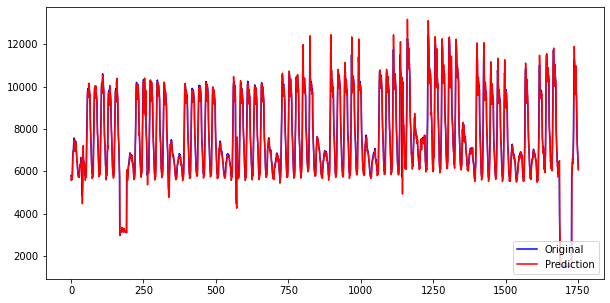

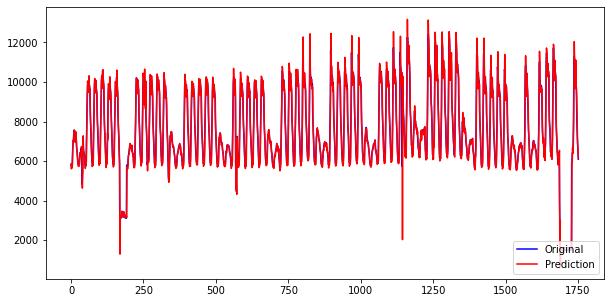

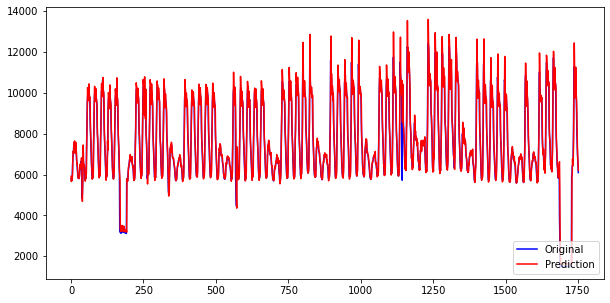

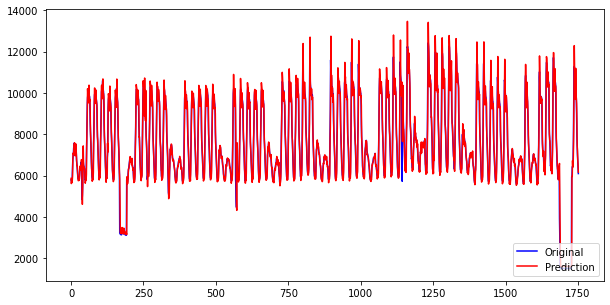

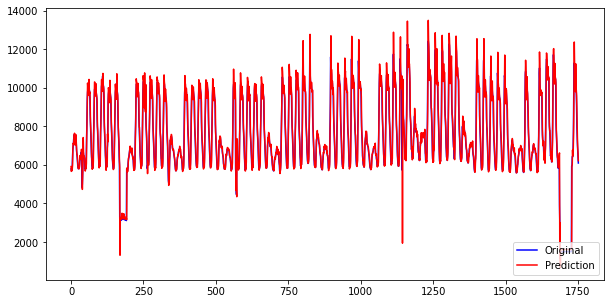

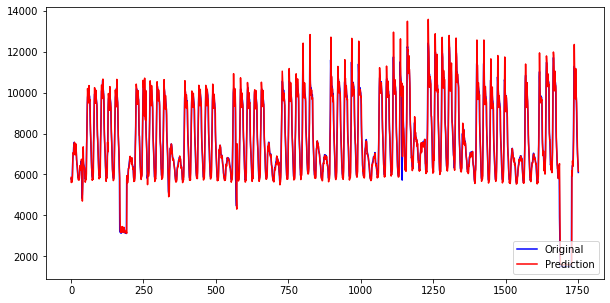

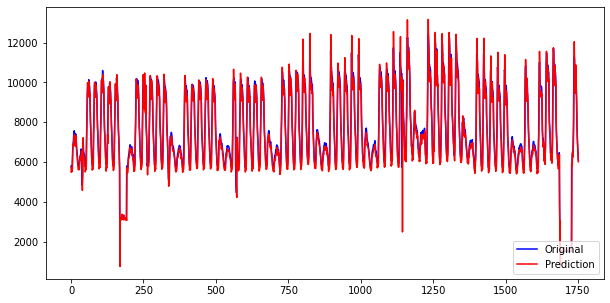

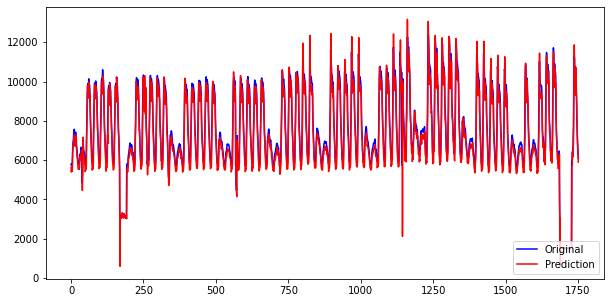

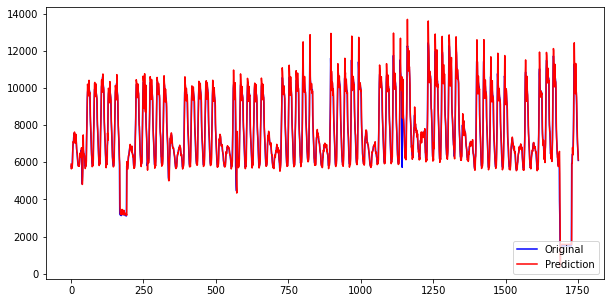

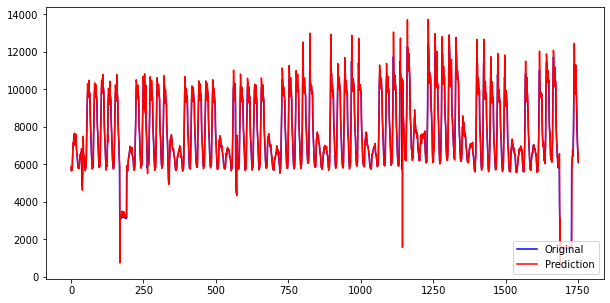

In [16]:
# data split
n_test = 2

# define config 
# n seq: The number of subsequences within a sample.
# n steps: The number of time steps within each subsequence.
# n filters: The number of parallel filters.
# n kernel: The number of time steps considered in each read of the input sequence.
# n nodes: The number of LSTM units to use in the hidden layer.
# n epochs: The number of times to expose the model to the whole training dataset.
# n batch: The number of samples within an epoch after which the weights are updated.

config = [1, 2, 64, 3, 200, 350, 100]
# grid search
scores = repeat_evaluate(data2, config, n_test)
# summarize scores
summarize_scores('cnn-lstm', scores)

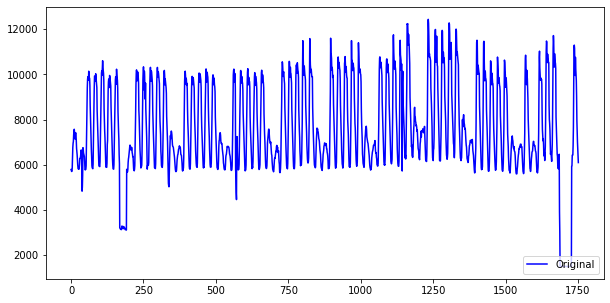

In [19]:
train, test = train_test_split(data2)
test_=np.array(test)[:,0]
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(test_, 'b', label='Original')
ax1.legend(loc="lower right")